In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import Adam
from torchvision.transforms import transforms, Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST
from torch.utils.data import DataLoader, random_split
from tools.models import *
import matplotlib.pyplot as plt
import numpy as np
import random
import imageio
from argparse import ArgumentParser
import einops
from tools.plot_utils import show_images, show_forward, generate_new_images
from tools.models import Autoencoder

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"./history/ddpm_model_mnist.pt"
STORE_PATH_SYNTH = f"./history/ddpm_model_synth.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_losses = []
test_losses = []


def training_loop(dataset, ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps
    for epoch in range(num_epochs):
        train_loss = 0
        for data in train_dataloader:
            # Loading data
            if dataset =="MNIST":
                x0 = data[0].to(device)
            elif dataset == "Synthetic":
                x0 = data["image"].float().to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta, _ = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            train_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {train_loss:.3f}"
    
        # Storing the model
        if best_loss > train_loss:
            best_loss = train_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [9]:
# Hyperparameters
dataset = "MNIST"
store_path = f"./history/ddpm_model_{dataset}.pt"
batch_size = 128
learning_rate = 0.001
num_epochs = 20
input_channel = 3 if dataset == "Synthetic" else 1

# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
if dataset == "MNIST":
    ds_fn = MNIST
    dataset_fn = ds_fn("./datasets", download=True, train=True, transform=transform)

if dataset == "Synthetic":
    # Use enough images to get great generation
    data_folder = "./data/Synthetic/10images_28by28pixels_4_distanced_grid_pins_4seed"
    dataset_fn = PinDataset(csv_file=f"{data_folder}/pins.csv",
                                  root_dir=f"{data_folder}/images/",
                                  transform=transforms.Compose([ToTensor(), Resize()])
                        )


train_dataloader = DataLoader(dataset_fn, batch_size, shuffle=True)

# Initialize the autoencoder
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
model = DDPM(UNet(input_channel), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loop(dataset, model, train_dataloader, num_epochs, optimizer, device, store_path=store_path)

Loss at epoch 1: 0.187 --> Best model ever (stored)
Loss at epoch 2: 0.054 --> Best model ever (stored)
Loss at epoch 3: 0.045 --> Best model ever (stored)
Loss at epoch 4: 0.041 --> Best model ever (stored)
Loss at epoch 5: 0.038 --> Best model ever (stored)
Loss at epoch 6: 0.037 --> Best model ever (stored)
Loss at epoch 7: 0.036 --> Best model ever (stored)
Loss at epoch 8: 0.035 --> Best model ever (stored)
Loss at epoch 9: 0.034 --> Best model ever (stored)
Loss at epoch 10: 0.033 --> Best model ever (stored)
Loss at epoch 11: 0.033 --> Best model ever (stored)
Loss at epoch 12: 0.033
Loss at epoch 13: 0.032 --> Best model ever (stored)
Loss at epoch 14: 0.032 --> Best model ever (stored)
Loss at epoch 15: 0.031 --> Best model ever (stored)
Loss at epoch 16: 0.031 --> Best model ever (stored)
Loss at epoch 17: 0.031 --> Best model ever (stored)
Loss at epoch 18: 0.031
Loss at epoch 19: 0.030 --> Best model ever (stored)
Loss at epoch 20: 0.030


Model loaded
Generating new images


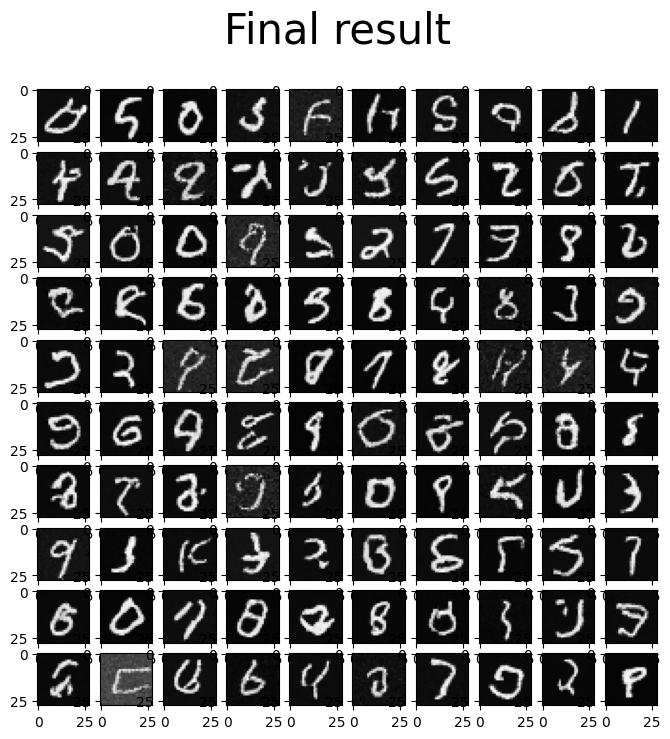

In [10]:
# Loading the trained model
store_path = f"./history/ddpm_model_{dataset}.pt"
best_model = DDPM(UNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="mnist.gif"
    )
show_images(generated, "Final result")

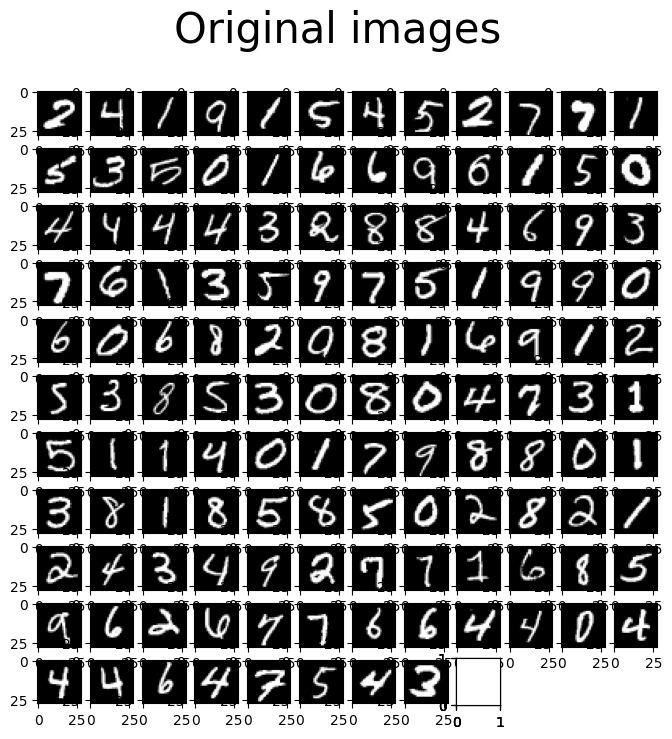

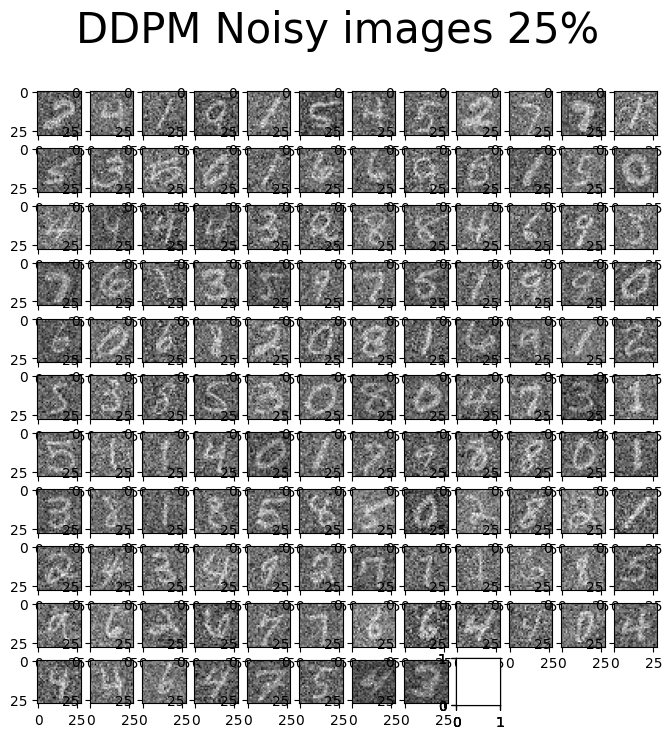

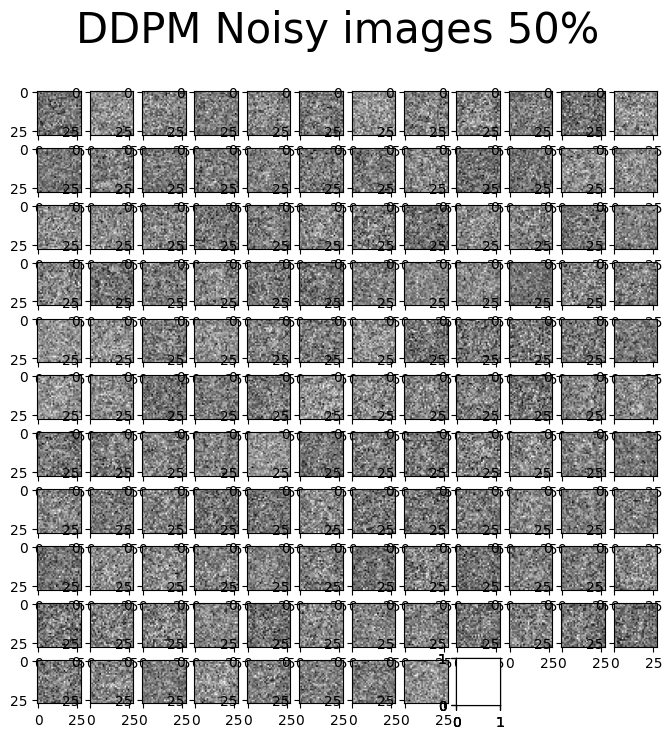

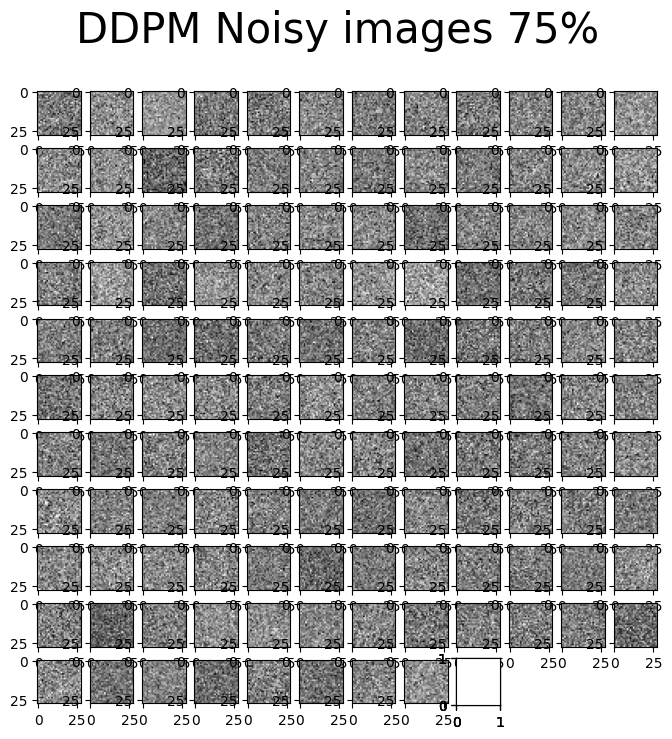

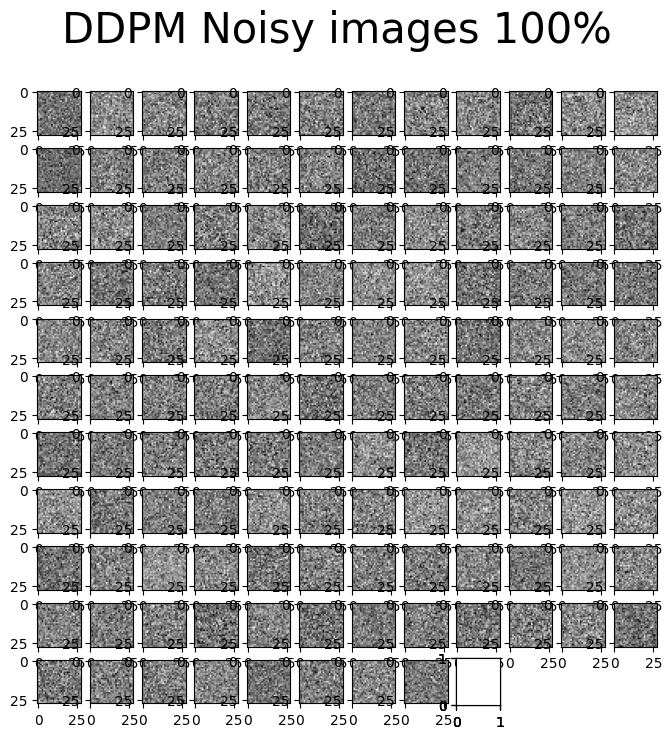

In [4]:
show_forward(model, train_dataloader, device)

In [6]:
# Visual evaluation on the test set

# change for dataset
num_kernels_encoder = [16, 8]
num_kernels_decoder = [16]
input_channel = 1

test_dataloader = DataLoader(dataset, batch_size, shuffle=True)

with torch.no_grad():
    for data in test_dataloader:
        inputs, _ = data
        inputs = inputs.view(inputs.size(0), -1)
        
        # Forward pass through the autoencoder
        autoencoder = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
        outputs = autoencoder(inputs)
        
        # Reshape the outputs to the original image shape (28x28)
        outputs = outputs.view(outputs.size(0), 1, 28, 28)
        
        # Convert Tensors to NumPy arrays for visualization
        inputs = inputs.view(inputs.size(0), 1, 28, 28).numpy()
        outputs = outputs.numpy()
        
        # Plot the input and output images
        for i in range(inputs.shape[0]):
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.title('Input Image')
            plt.imshow(np.squeeze(inputs[i]), cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.title('Output Image')
            plt.imshow(np.squeeze(outputs[i]), cmap='gray')
            plt.axis('off')
            plt.show()

ValueError: too many values to unpack (expected 2)